In [59]:
import tensorflow as tf
import tensorflow_datasets as tfds # Get TensorFlow Datasets
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from helper_functions import plot_loss_curves,checkModelLayers
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

In [2]:
#check if datasets list contain food101
datasets_list = tfds.list_builders()
print("food101" in datasets_list )

True


In [3]:
#loading in data food101 from data
(train_data, test_data), das_info=tfds.load(name="food101",
                                            split=["train", "validation"],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True)

In [4]:
#check the dataset
das_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [5]:
# Get class names
class_names = das_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [87]:
class_names[18]

'chicken_curry'

In [10]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
      print(f"""
      Image shape: {image.shape}
      Image dtype: {image.dtype}
      Target class from Food101 (tensor form): {label}
      Class name (str form): {class_names[label.numpy()]}
            """)


      Image shape: (512, 512, 3)
      Image dtype: <dtype: 'uint8'>
      Target class from Food101 (tensor form): 31
      Class name (str form): donuts
            


In [12]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[131,  86,  55],
        [134,  89,  58],
        [137,  92,  61],
        ...,
        [131,  44,   0],
        [135,  49,   2],
        [138,  52,   5]],

       [[134,  89,  58],
        [135,  90,  59],
        [135,  90,  59],
        ...,
        [133,  46,   1],
        [134,  48,   1],
        [134,  48,   1]],

       [[136,  91,  60],
        [137,  92,  61],
        [139,  94,  63],
        ...,
        [137,  53,   7],
        [135,  51,   5],
        [131,  47,   1]],

       ...,

       [[130,  23,   3],
        [134,  31,  14],
        [132,  36,  24],
        ...,
        [243, 248, 242],
        [243, 248, 242],
        [243, 248, 242]],

       [[128,  22,   0],
        [129,  26,   7],
        [124,  28,  14],
        ...,
        [243, 248, 241],
        [242, 247, 240],
        [242, 247, 240]],

       [[132,  26,   2],
        [133,  31,   9],
        [126,  29,  13],
        ...,
        [242, 247, 24

(-0.5, 511.5, 511.5, -0.5)

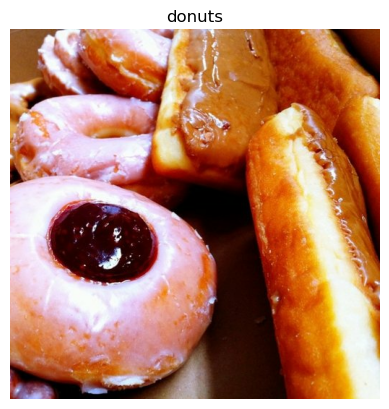

In [13]:
# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False)

#### preprocessing the data to fit the model
<ul>
    <li>float32 data type</li>
    <li>Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))</li>
    <li>Scaled (values between 0 & 1), also called normalized</li>
</ul>

In [14]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [15]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[1.34030609e+02 8.90306168e+01 5.80306129e+01]
  [1.36045914e+02 9.10459213e+01 6.00459175e+01]
  [1.37846939e+02 9.28469391e+01 6.38469391e+01]
  ...
  [1.30265366e+02 4.79183846e+01 1.62753057e+00]
  [1.30760223e+02 4.37602272e+01 4.59267795e-02]
  [1.34739838e+02 4.87398338e+01 1.73983324e+00]]

 [[1.41551025e+02 9.65510254e+01 6.55510254e+01]
  [1.49081650e+02 1.04081635e+02 7.30816345e+01]
  [1.51632660e+02 1.06632652e+02 7.56326523e+01]
  ...
  [1.30357101e+02 4.85713654e+01 1.99989128e+00]
  [1.34147995e+02 5.01479988e+01 4.14799976e+00]
  [1.33571289e+02 4.95712891e+01 3.57128906e+00]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


(-0.5, 223.5, 223.5, -0.5)

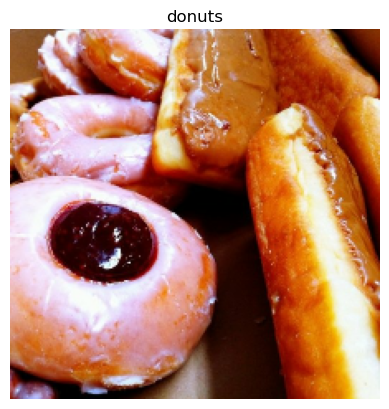

In [16]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)

In [17]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [19]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

#### To build the feature extraction model:
<ul>
<li>Use EfficientNetB0 from tf.keras.applications pre-trained on ImageNet as our base model</li>
<li>We'll download this without the top layers using include_top=False parameter so we can create our own output layers</li>
<li>Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet</li>
<li>Put together the input, base model, pooling and output layers in a Functional model</li>
<li>Compile the Functional model using the Adam optimizer and sparse categorical crossentropy as the loss function (since our labels aren't one-hot encoded)</li>
<li>Fit the model for 3 epochs using the ModelCheckpoint callbacks</li>
</ul>


In [20]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [21]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [22]:
# Check the dtype_policy attributes of layers in our model
checkModelLayers(model)

layer Name  Layer Status layer Data Type layer DataType Policy
0      input_layer          True         float32    <Policy "float32">
1   efficientnetb0         False         float32    <Policy "float32">
2    pooling_layer          True         float32    <Policy "float32">
3            dense          True         float32    <Policy "float32">
4  softmax_float32          True         float32    <Policy "float32">

In [23]:
checkModelLayers(model.layers[1])

layer Name  Layer Status layer Data Type layer DataType Policy
0                 input_1         False         float32    <Policy "float32">
1               rescaling         False         float32    <Policy "float32">
2           normalization         False         float32    <Policy "float32">
3           stem_conv_pad         False         float32    <Policy "float32">
4               stem_conv         False         float32    <Policy "float32">
..                    ...           ...             ...                   ...
232  block7a_project_conv         False         float32    <Policy "float32">
233    block7a_project_bn         False         float32    <Policy "float32">
234              top_conv         False         float32    <Policy "float32">
235                top_bn         False         float32    <Policy "float32">
236        top_activation         False         float32    <Policy "float32">

[237 rows x 4 columns]

In [24]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - 197s 80ms/step - loss: 1.8194 - accuracy: 0.5571 - val_loss: 1.2194 - val_accuracy: 0.6758
Epoch 2/3
2368/2368 [==============================] - 194s 81ms/step - loss: 1.2935 - accuracy: 0.6666 - val_loss: 1.1120 - val_accuracy: 0.7021
Epoch 3/3
2368/2368 [==============================] - 195s 82ms/step - loss: 1.1423 - accuracy: 0.7031 - val_loss: 1.0888 - val_accuracy: 0.7055


In [25]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 57s 72ms/step - loss: 1.0867 - accuracy: 0.7074


[1.0866832733154297, 0.7074455618858337]

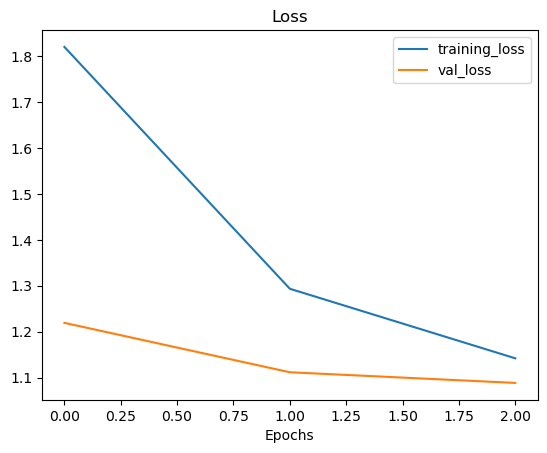

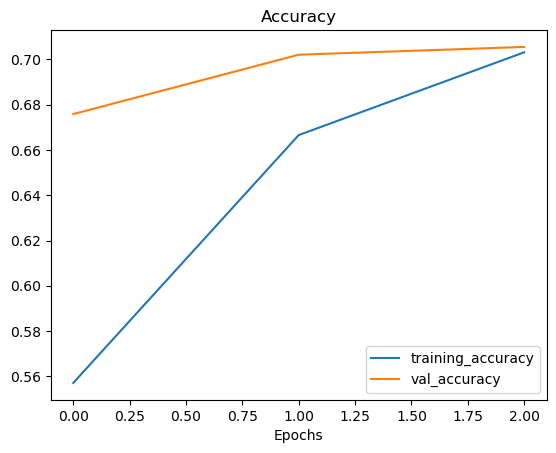

In [26]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [27]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [28]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [29]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 56s 70ms/step - loss: 1.0867 - accuracy: 0.7074


[1.0866844654083252, 0.7074455618858337]

In [34]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

### we will fine tune the model

🔑 Note: If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

In [36]:
loaded_gs_model = tf.keras.models.load_model("07_efficientnetb0_feature_extract_model_mixed_precision")

In [37]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [39]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 55s 69ms/step - loss: 1.0867 - accuracy: 0.7074


[1.086683750152588, 0.7074455618858337]

In [43]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
    layer.trainable = True # set all layers to trainable

# Are any of the layers in our model frozen?
checkModelLayers(loaded_gs_model)


layer Name  Layer Status layer Data Type layer DataType Policy
0      input_layer          True         float32    <Policy "float32">
1   efficientnetb0          True         float32    <Policy "float32">
2    pooling_layer          True         float32    <Policy "float32">
3            dense          True         float32    <Policy "float32">
4  softmax_float32          True         float32    <Policy "float32">

In [46]:
# Are any of the layers in our model frozen?
checkModelLayers(loaded_gs_model.layers[1])

layer Name  Layer Status layer Data Type layer DataType Policy
0                 input_1          True         float32    <Policy "float32">
1               rescaling          True         float32    <Policy "float32">
2           normalization          True         float32    <Policy "float32">
3           stem_conv_pad          True         float32    <Policy "float32">
4               stem_conv          True         float32    <Policy "float32">
..                    ...           ...             ...                   ...
232  block7a_project_conv          True         float32    <Policy "float32">
233    block7a_project_bn          True         float32    <Policy "float32">
234              top_conv          True         float32    <Policy "float32">
235                top_bn          True         float32    <Policy "float32">
236        top_activation          True         float32    <Policy "float32">

[237 rows x 4 columns]

<p>We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means the model's training time is probably going to be much longer than before.</p>

<p>It could be a couple of hours or in the case of the DeepFood paper (the baseline we're trying to beat), their best performing model took 2-3 days of training time.</p>

<p>we should stop training when the model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.</p>

<p>Luckily, there's a solution: the <strong>EarlyStopping callback<strong>.</p>

In [47]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [48]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [49]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Epoch 1/100
2368/2368 [==============================] - 853s 356ms/step - loss: 0.9253 - accuracy: 0.7522 - val_loss: 0.8064 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 840s 354ms/step - loss: 0.5802 - accuracy: 0.8395 - val_loss: 0.7864 - val_accuracy: 0.7860 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 809s 341ms/step - loss: 0.3297 - accuracy: 0.9071 - val_loss: 0.8660 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9493
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 811s 342ms/step - loss: 0.1734 - accuracy: 0.9493 - val_loss: 0.9683 - val_accuracy: 0.7855 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 813s 343ms/step - loss: 0.0353 - accuracy: 0.9920 - val_loss: 1.0488 - val_accuracy: 0.8001 - lr: 2.0000e-05


In [50]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 57s 71ms/step - loss: 1.0664 - accuracy: 0.7987


[1.0664407014846802, 0.798693060874939]

In [51]:
# Get a model summary 
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [52]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

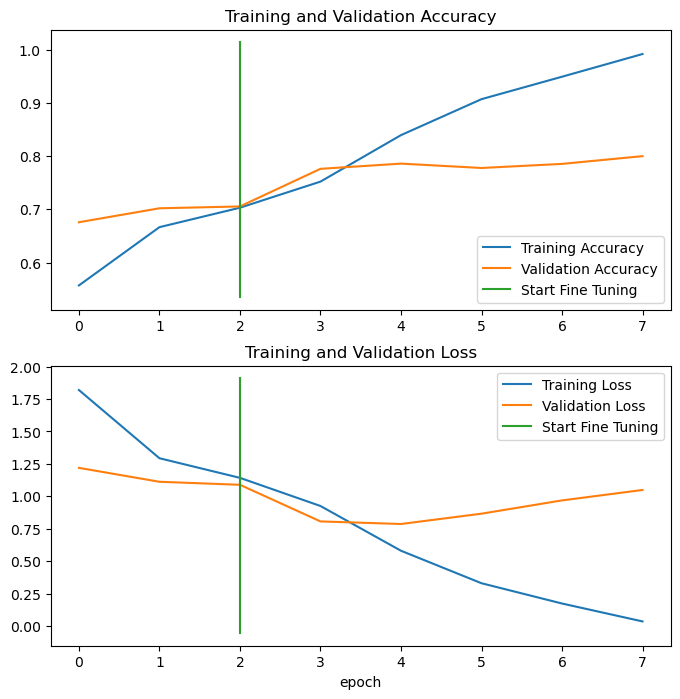

In [53]:
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_101_food_classes_all_data_fine_tune,
                 initial_epochs=3)

In [54]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [55]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [56]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [77]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 56s 71ms/step - loss: 1.0664 - accuracy: 0.7987


[1.066440463066101, 0.798693060874939]

### Confusion Matrix

In [60]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [86]:
# print(test_data.unbatch())
y_labels=[]
for images,label in test_data.unbatch():
    print(f"label = {label.numpy()}")
    y_labels.append(label.numpy())
y_labels[78]

label = 78
label = 100
label = 79
label = 84
label = 60
label = 29
label = 80
label = 32
label = 78
label = 17
label = 1
label = 40
label = 40
label = 99
label = 1
label = 71
label = 42
label = 6
label = 44
label = 83
label = 16
label = 60
label = 32
label = 36
label = 94
label = 48
label = 0
label = 65
label = 29
label = 56
label = 37
label = 87
label = 65
label = 64
label = 26
label = 37
label = 99
label = 40
label = 60
label = 1
label = 69
label = 52
label = 62
label = 77
label = 67
label = 12
label = 96
label = 53
label = 70
label = 44
label = 71
label = 57
label = 48
label = 79
label = 44
label = 81
label = 43
label = 27
label = 47
label = 46
label = 22
label = 99
label = 70
label = 100
label = 90
label = 21
label = 59
label = 83
label = 80
label = 45
label = 28
label = 23
label = 30
label = 72
label = 45
label = 94
label = 92
label = 46
label = 18
label = 99
label = 75
label = 16
label = 40
label = 42
label = 57
label = 46
label = 69
label = 100
label = 38
label = 10
label = 86
l

18

In [81]:
np.sum(y_labels)

0

In [67]:

# Make predictions with model
pred_probs = loaded_fine_tuned_gs_model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 55s 67ms/step


In [68]:
# How many predictions are there?
len(pred_probs)

25250

In [90]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [2.4438691e-03 6.9942442e-03 1.7415245e-07 4.8305537e-10 2.4909719e-09
 9.3464783e-09 1.9130143e-10 4.8226683e-12 6.5975060e-04 5.3198821e-08
 4.9521250e-06 4.6935880e-12 4.3147933e-11 2.1276420e-11 7.9740780e-12
 7.7545309e-08 5.9979972e-11 2.2307303e-09 1.5404841e-01 1.4161277e-09
 4.9612775e-02 2.7817499e-12 7.4225220e-10 1.7654796e-05 1.4481382e-12
 1.9443137e-15 5.6311213e-09 1.7758461e-07 3.8818250e-12 7.9348014e-15
 1.2002367e-13 2.2537905e-09 4.8079833e-06 1.1450486e-10 1.0079998e-09
 1.0884472e-07 1.5451948e-15 3.1106447e-06 7.4915411e-06 2.9122457e-04
 7.9495994e-06 4.3040768e-10 1.7666474e-06 1.7291720e-07 1.0886219e-12
 2.4840530e-10 9.8200115e-10 1.0822134e-03 2.1787269e-13 6.8648942e-10
 3.6554840e-05 1.2491538e-13 7.4234689e-05 2.1433245e-10 1.2891474e-10
 6.0134613e-11 7.6113977e-09 9.3284198e-09 5.2574286e-13 1.6391055e-04
 1.1179342e-11 1.0847336e-12 2.6756692e-05 4.

In [93]:
y_labels[0]

78

In [94]:
class_names[78]

'poutine'

In [69]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [70]:
# How do they look?
pred_probs[:10]

array([[2.44386913e-03, 6.99424418e-03, 1.74152447e-07, ...,
        5.58249519e-13, 3.59496539e-07, 2.39503079e-05],
       [1.74653458e-09, 1.16292061e-18, 2.85039970e-14, ...,
        1.02635935e-08, 1.06082799e-11, 1.00000000e+00],
       [1.40600256e-17, 3.05538150e-09, 1.83717517e-18, ...,
        4.33936334e-15, 5.65066746e-22, 9.56040044e-22],
       ...,
       [3.68350246e-11, 9.72355226e-13, 6.96288470e-12, ...,
        3.70580122e-10, 6.34665445e-11, 7.23052285e-09],
       [1.87328872e-08, 1.05612035e-08, 2.97462632e-09, ...,
        1.44438550e-08, 7.13224888e-01, 6.24741991e-09],
       [6.69262558e-02, 1.06666542e-08, 2.88174851e-05, ...,
        1.44322838e-08, 4.80677409e-09, 2.03636257e-11]], dtype=float32)

In [71]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 78, 100,  79,   4,  37,  22,  42,  12,  99,  44], dtype=int64)

In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))
     

              precision    recall  f1-score   support

           0       0.02      0.02      0.02       250
           1       0.02      0.02      0.02       250
           2       0.01      0.01      0.01       250
           3       0.02      0.02      0.02       250
           4       0.02      0.02      0.02       250
           5       0.02      0.02      0.02       250
           6       0.02      0.02      0.02       250
           7       0.02      0.02      0.02       250
           8       0.01      0.01      0.01       250
           9       0.01      0.01      0.01       250
          10       0.03      0.03      0.03       250
          11       0.01      0.01      0.01       250
          12       0.03      0.03      0.03       250
          13       0.01      0.01      0.01       250
          14       0.02      0.02      0.02       250
          15       0.02      0.02      0.02       250
          16       0.02      0.02      0.02       250
          17       0.02    

In [88]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

### Make a function to take the image from the test and from the prediciton and make sure its the same picture and the prediction really make the the wrogn prediction